In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

In [13]:
# load data
data = pd.read_csv('data/bank-additional.csv', delimiter=';')

# no missing values as per dataset documentation
# dropping null values out of caution
data = data.dropna(axis=1)

data = data.drop('duration', axis=1)

print(data.describe())

               age     campaign        pdays     previous  emp.var.rate  \
count  4119.000000  4119.000000  4119.000000  4119.000000   4119.000000   
mean     40.113620     2.537266   960.422190     0.190337      0.084972   
std      10.313362     2.568159   191.922786     0.541788      1.563114   
min      18.000000     1.000000     0.000000     0.000000     -3.400000   
25%      32.000000     1.000000   999.000000     0.000000     -1.800000   
50%      38.000000     2.000000   999.000000     0.000000      1.100000   
75%      47.000000     3.000000   999.000000     0.000000      1.400000   
max      88.000000    35.000000   999.000000     6.000000      1.400000   

       cons.price.idx  cons.conf.idx    euribor3m  nr.employed  
count     4119.000000    4119.000000  4119.000000  4119.000000  
mean        93.579704     -40.499102     3.621356  5166.481695  
std          0.579349       4.594578     1.733591    73.667904  
min         92.201000     -50.800000     0.635000  4963.600000  

In [14]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size = 0.2, random_state = 42) 

In [16]:
# looking for any inconsistencies in categorial data
print("job = " + ", ".join(data['job'].unique()))
print("marital = " + ", ".join(data['marital'].unique()))
print("education = " + ", ".join(data['education'].unique()))
print("default = " + ", ".join(data['default'].unique()))
print("housing = " + ", ".join(data['housing'].unique()))
print("loan = " + ", ".join(data['loan'].unique()))
print("contact = " + ", ".join(data['contact'].unique()))
print("month = " + ", ".join(data['month'].unique()))
print("day_of_week = " + ", ".join(data['day_of_week'].unique()))
print("poutcome = " + ", ".join(data['poutcome'].unique()))

job = blue-collar, services, admin., entrepreneur, self-employed, technician, management, student, retired, housemaid, unemployed, unknown
marital = married, single, divorced, unknown
education = basic.9y, high.school, university.degree, professional.course, basic.6y, basic.4y, unknown, illiterate
default = no, unknown, yes
housing = yes, no, unknown
loan = no, unknown, yes
contact = cellular, telephone
month = may, jun, nov, sep, jul, aug, mar, oct, apr, dec
day_of_week = fri, wed, mon, thu, tue
poutcome = nonexistent, failure, success


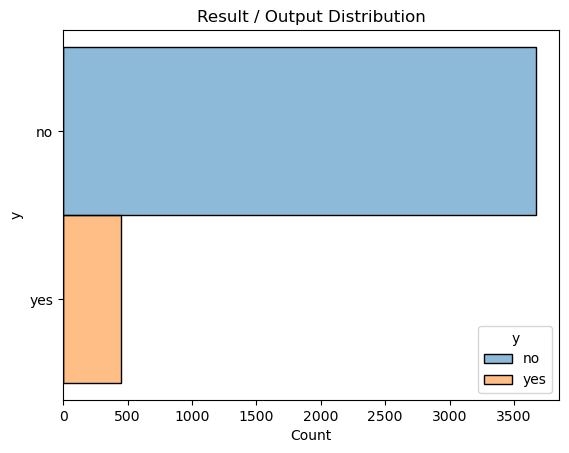

In [17]:
# Checking the distribution of output for yes / no
sns.histplot(data=data, y="y", hue="y").set_title("Result / Output Distribution")
plt.show()

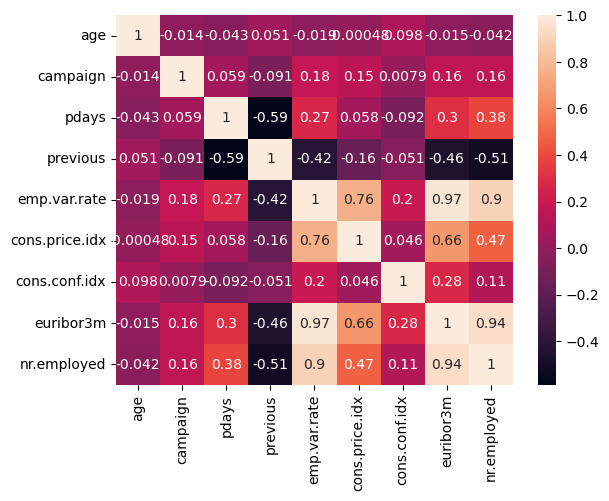

In [18]:
# plotting correlation heatmap for numerical features
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True) 
# displaying heatmap 
plt.show() 

In [19]:
def evaluate(name, model, preprocessor, params):
    '''
    This function takes classifier, verctorizer and params
    and evaluate the model.

    Arguments
    ---------
    name: string
        Name / description of the model / estimator
    vectorizer: object
        Vectorizer to use (CountVectorizer or Tfidf)
    classifier: object
        Classifier / estimator to evaluate
    params: dictionary
        Parameters to use by GridSearchCV
    Returns
    -------
        Dataframe containing name, fit-time, accuracy, precision, recall, f1-score, train-accuracy best-params, and predictions
    ''' 
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    start = time.time()
    grid = GridSearchCV(pipe, param_grid=params, scoring = 'accuracy')
    grid.fit(X_train, y_train)
    end = time.time()
    preds = grid.best_estimator_.predict(X_test)
    train_acc = grid.score(X_train, y_train)
    test_acc = grid.score(X_test, y_test)

    return pd.DataFrame([{
        'name': name, 
        'fit-time': round((end - start), 2),
        'accuracy': round(accuracy_score(y_test, preds), 2),
        'precision': round(precision_score(y_test, preds, average='weighted'), 2),
        'recall': round(recall_score(y_test, preds, average='weighted'), 2),
        'f1-score': round(f1_score(y_test, preds, average='weighted'), 2),
        'train-accuracy': round(train_acc, 2),
        'best-params': grid.best_params_,
        'preds': preds
    }])

In [20]:
# transformer with OHE to convert categorical data and StandardScaler to scaler numerical columns
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'if_binary', handle_unknown='ignore'), X_train.keys()),
    remainder = StandardScaler()
)

# dataframe to store evaluation results
result = pd.DataFrame()

# KNearest neighbors classifier evaluation
df = evaluate('KNeighborsClassifier', KNeighborsClassifier(), transformer, {'model__n_neighbors': range(1, 33, 2)})
result = pd.concat([result, df], ignore_index=True)

# Logistic regression evaluation
df = evaluate('LogisticRegression', LogisticRegression(), transformer, {'model__C': [0.01,0.1,1,10,100]})
result = pd.concat([result, df], ignore_index=True)

# Decision Tree classifier evaluation
df = evaluate('DecisionTreeClassifier', DecisionTreeClassifier(), transformer, {'model__max_depth': [1,5,10,20]})
result = pd.concat([result, df], ignore_index=True)

# Support vector machine evaluation
df = evaluate('SVC', SVC(), transformer, {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})
result = pd.concat([result, df], ignore_index=True)

In [21]:
# peek at the evaluation results
result.drop("preds", axis=1).head()

,name,fit-time,accuracy,precision,recall,f1-score,train-accuracy,best-params
0,KNeighborsClassifier,34.20,0.9,0.90,0.9,0.86,0.91,{'model__n_neighbors': 15}
1,LogisticRegression,2.50,0.9,0.88,0.9,0.87,0.91,{'model__C': 0.1}
2,DecisionTreeClassifier,1.10,0.9,0.87,0.9,0.87,0.90,{'model__max_depth': 1}
3,SVC,11.48,0.9,0.88,0.9,0.87,0.90,{'model__kernel': 'sigmoid'}


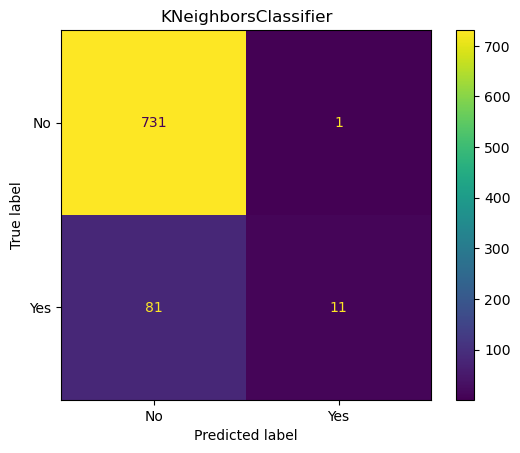

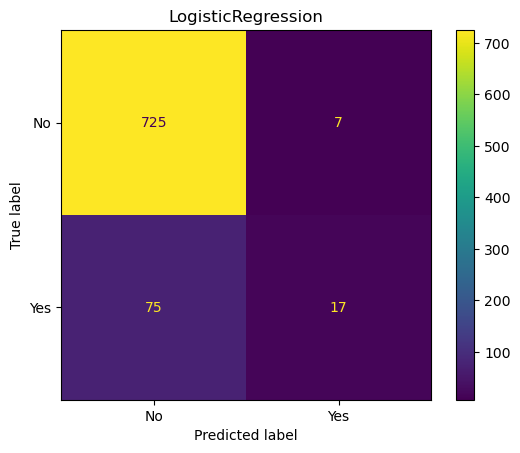

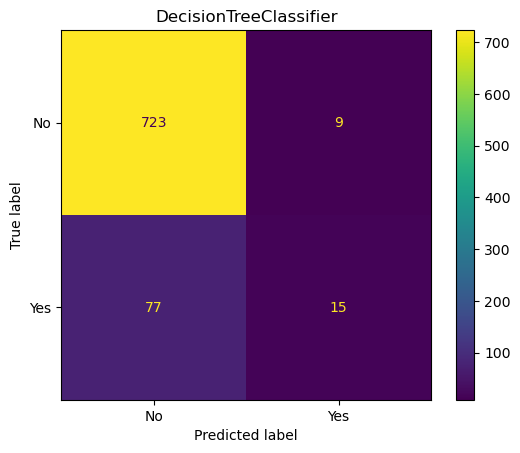

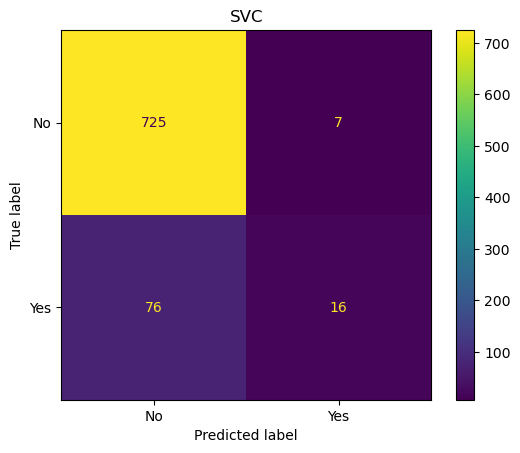

In [22]:
# confusion matrices for all evaluation results
labels = ['No', 'Yes']
for i in range(0, 4):
    cm = confusion_matrix(y_test, result.at[i,'preds'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()    
    disp.ax_.set_title(result.at[i,'name'])
    plt.show()